In [1]:
import creds

import os
import datetime
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import requests
from sentinelhub import SHConfig, SentinelHubCatalog, SentinelHubRequest, BBox, CRS, bbox_to_dimensions, DataCollection
from shapely.geometry import box, shape
import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
import sweetviz as sv
import xgboost as xgb
from xgboost import XGBClassifier

# 1.Data Acquisition and Preprocessing

## Sentinel data

### Set search parameters

In [2]:
# Area of Interest
aoi_coords_wgs84 = [89.173964,23.442364,90.585284,24.935541]
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)

# Time interval
time_interval = '2014-04-01', '2016-12-31'

### Catalog API

In [3]:
config = SHConfig()
config.sh_client_id = creds.client_id
config.sh_client_secret = creds.client_secret
config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

In [4]:
catalog = SentinelHubCatalog(config=config)

In [5]:
# Search SentinelHub catalog for images that intersect the AOI, within the given time interval
search_iterator = catalog.search(
    DataCollection.SENTINEL1,
    bbox=aoi_bbox,
    time=time_interval,
    fields={"include": ["id", "properties.datetime", "geometry", "bbox"]},

)
results = list(search_iterator)
print("Total number of results, for the given time-frame:", len(results))

Total number of results, for the given time-frame: 239


In [6]:
# Add results to a data-frame
catalog_df = pd.DataFrame()
catalog_df['id'] = [item["id"] for item in results]
catalog_df['timestamp'] = [item["properties"]["datetime"] for item in results]
catalog_df['polygon'] = [item["geometry"]["coordinates"][0] for item in results]
catalog_df.head()

,id,timestamp,polygon
0,S1A_IW_GRDH_1SSV_20161230T121253_20161230T1213...,2016-12-30T12:12:53Z,"[[86.89816160278917, 24.530804862398835], [87...."
1,S1B_IW_GRDH_1SSV_20161227T000244_20161227T0003...,2016-12-27T00:02:44Z,"[[89.59724839431408, 25.930054004510048], [89...."
2,S1A_IW_GRDH_1SSV_20161225T120445_20161225T1205...,2016-12-25T12:04:45Z,"[[88.91069384866643, 24.73008125600709], [89.2..."
3,S1A_IW_GRDH_1SSV_20161225T120420_20161225T1204...,2016-12-25T12:04:20Z,"[[89.23065369908844, 23.22044103244167], [89.8..."
4,S1A_IW_GRDH_1SSV_20161225T120351_20161225T1204...,2016-12-25T12:03:51Z,"[[89.57379999711375, 21.5902141265807], [90.17..."


#### Visualise results on a map

In [7]:
import folium
import geopandas as gpd
from shapely.geometry import Polygon

# Calculate the center of the bounding box of the first retrieved image (this is just a proxy to center the map)
bbox = results[0]['bbox']
center = [(bbox[1] + bbox[3]) / 2, (bbox[0] + bbox[2]) / 2]

# Create a Folium map centered at the calculated center
m = folium.Map(location=center, zoom_start=7, tiles="CartoDB positron")

# Create a rectangle overlay using the bounding box coordinates
folium.GeoJson(
        aoi_bbox.geometry,
        style_function=lambda feature: {
            "fillColor": 'red',
            "color": "red",
            "weight": 1,
            "fillOpacity": 0.5,
        },
        ).add_to(m)

# Sentinel images
for i in range(0, len(results)):
    polygon_geom = Polygon(catalog_df.polygon[i])
    polygon = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[polygon_geom])    

    folium.GeoJson(
        polygon,
        style_function=lambda feature: {
            "fillColor": 'blue',
            "color": "blue",
            "weight": 1,
            "dashArray": "5, 5",
            "fillOpacity": 0.005,
        },
        ).add_to(m)
 
m

### Sentinel Revisit times

In [8]:
timestamps_df = catalog_df.copy()
timestamps_df['timestamp'] = pd.to_datetime(timestamps_df['timestamp'])
timestamps_df.set_index('timestamp', inplace=True)

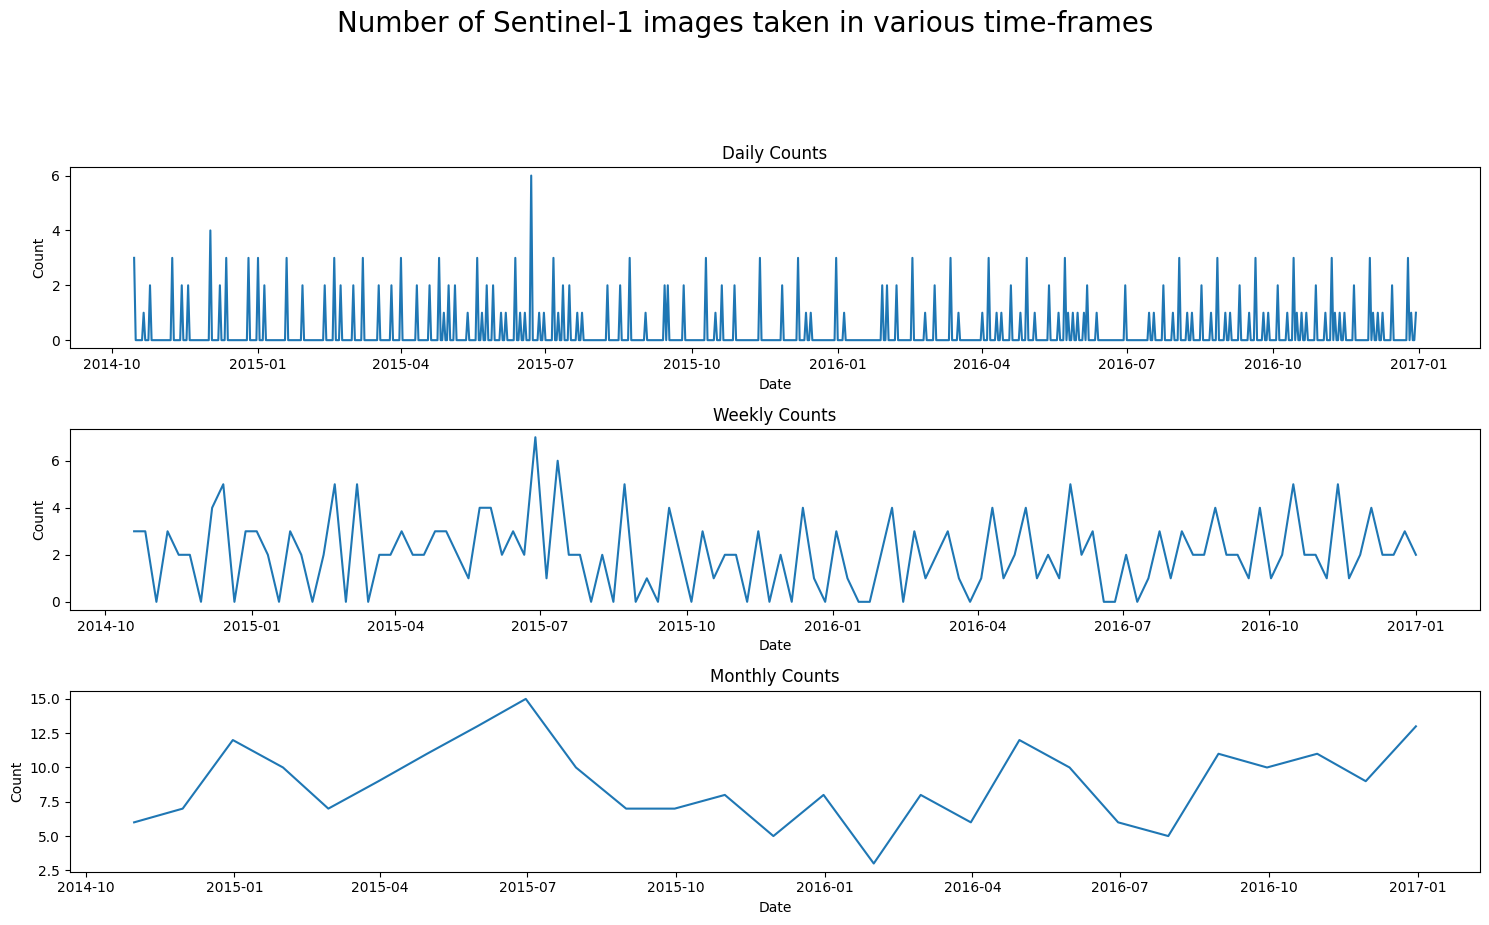

In [9]:
# Resample the data to count rows per day, week, and month
daily_counts = timestamps_df.resample('D').count()
weekly_counts = timestamps_df.resample('W').count()
monthly_counts = timestamps_df.resample('ME').count()

fig, ax = plt.subplots(3, 1, figsize=(15, 8))
for idx, (count_name, count_val) in enumerate([('Daily Counts', daily_counts), ('Weekly Counts', weekly_counts), ('Monthly Counts', monthly_counts), ]): 

    ax[idx].plot(count_val.index, count_val['id'].to_list())
    ax[idx].set_xlabel('Date')
    ax[idx].set_ylabel('Count')
    ax[idx].set_title(count_name)


plt.tight_layout()
plt.suptitle('Number of Sentinel-1 images taken in various time-frames', fontsize = 20, y = 1.15)
plt.show()

In [10]:
# Convert timestamps to datetime objects
timestamps = [datetime.strptime(ts, '%Y-%m-%dT%H:%M:%SZ') for ts in catalog_df['timestamp']]

# Deduplicate timestamps (i.e. double timestamps within the same day)
# Dictionary to store the minimum datetime per date
min_datetimes = {}

# Iterate through the list of datetimes
for dt in timestamps:
    # Extract date part from datetime
    date = dt.date()
    # Check if the date is already in the dictionary
    if date not in min_datetimes:
        # If not, add it with the current datetime as minimum
        min_datetimes[date] = dt
    else:
        # If yes, update the minimum datetime if the current datetime is smaller
        if dt < min_datetimes[date]:
            min_datetimes[date] = dt

# Extract the minimum datetimes
timestamps_filter = list(min_datetimes.values())

# Sort timestamps
sorted_timestamps = sorted(timestamps_filter)

# Calculate time differences between consecutive timestamps
time_differences = [(sorted_timestamps[i + 1] - sorted_timestamps[i]).total_seconds() for i in range(len(sorted_timestamps) - 1)]

# Calculate the average revisit time in days
average_revisit_time = sum(time_differences) / (len(time_differences) * 86400)

print("Average revisit time (days):", average_revisit_time)

Average revisit time (days): 6.300878544560185


## Flood data

In [11]:
# Directory containing the CSV files downloaded from Global Flood Database
directory = 'data/flood'

# List to store DataFrames read from CSV files
dfs = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        # Read the CSV file into a DataFrame
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        df['Event_id'] = '_'.join(filename.split('_')[:2])
        df['filename'] = os.path.splitext(filename)[0]
        
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
flood_df = pd.concat(dfs, ignore_index=True)
print(flood_df.shape)
flood_df.head()

(467, 4)


,Date,Precipication_mm,Event_id,filename
0,2014-06-23,26,DFO_4154,DFO_4154_Precip_PERSIANN_from_20140623_to_2014...
1,2014-06-24,17,DFO_4154,DFO_4154_Precip_PERSIANN_from_20140623_to_2014...
2,2011-08-15,59,DFO_3856,DFO_3856_Precip_PERSIANN_from_20110815_to_2011...
3,2011-08-16,57,DFO_3856,DFO_3856_Precip_PERSIANN_from_20110815_to_2011...
4,2011-08-17,19,DFO_3856,DFO_3856_Precip_PERSIANN_from_20110815_to_2011...


In [12]:
# Count distinct flood events
flood_df.Event_id.nunique()

23

In [13]:
# Calculate average flood duration
flood_df['flood_duration'] = flood_df.groupby('Event_id')['Date'].transform('count')

# Select one row for each distinct 'Event_id'
unique_events_df = flood_df.drop_duplicates(subset='Event_id')

# Calculate the average 'flood_duration'
average_flood_duration = unique_events_df['flood_duration'].mean()
print("\nAverage flood_duration:", average_flood_duration)

flood_df.head()


Average flood_duration: 20.304347826086957


,Date,Precipication_mm,Event_id,filename,flood_duration
0,2014-06-23,26,DFO_4154,DFO_4154_Precip_PERSIANN_from_20140623_to_2014...,2
1,2014-06-24,17,DFO_4154,DFO_4154_Precip_PERSIANN_from_20140623_to_2014...,2
2,2011-08-15,59,DFO_3856,DFO_3856_Precip_PERSIANN_from_20110815_to_2011...,24
3,2011-08-16,57,DFO_3856,DFO_3856_Precip_PERSIANN_from_20110815_to_2011...,24
4,2011-08-17,19,DFO_3856,DFO_3856_Precip_PERSIANN_from_20110815_to_2011...,24


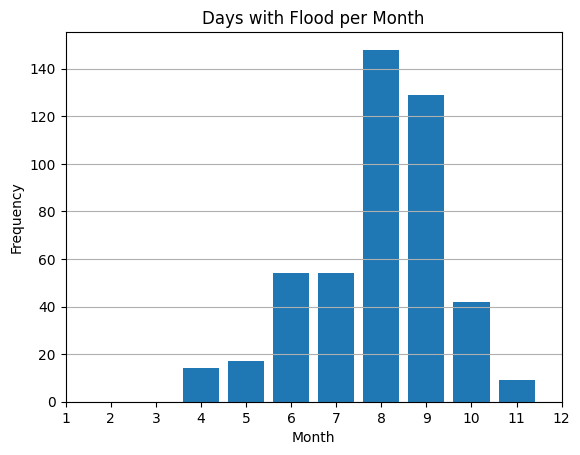

In [14]:
# Calculate month frequencies
month_frequencies = pd.to_datetime(flood_df['Date']).dt.month.value_counts().sort_index()

# Plot the histogram
plt.bar(month_frequencies.index, month_frequencies.values)
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Days with Flood per Month')
plt.xticks(range(1, 13))
plt.grid(axis='y')
plt.show()

In [15]:
# Deduplicate flood dates, i.e. same date being part of more than one flood events
flood_df['Date'] = pd.to_datetime(flood_df['Date'])
flood_df = flood_df.drop_duplicates(subset=['Date'])
flood_df.drop(['Precipication_mm'], axis=1, inplace=True)
print(flood_df.shape)
flood_df.head()

(338, 4)


,Date,Event_id,filename,flood_duration
0,2014-06-23,DFO_4154,DFO_4154_Precip_PERSIANN_from_20140623_to_2014...,2
1,2014-06-24,DFO_4154,DFO_4154_Precip_PERSIANN_from_20140623_to_2014...,2
2,2011-08-15,DFO_3856,DFO_3856_Precip_PERSIANN_from_20110815_to_2011...,24
3,2011-08-16,DFO_3856,DFO_3856_Precip_PERSIANN_from_20110815_to_2011...,24
4,2011-08-17,DFO_3856,DFO_3856_Precip_PERSIANN_from_20110815_to_2011...,24


#### Sample flood image

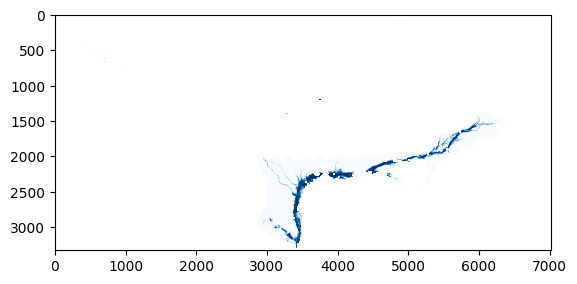

In [16]:
with rasterio.open('data/flood/tif/DFO_4176_From_20140815_to_20140908.tif') as src:
    # Read the first band, Indexing starts from 1
    first_band = src.read(1)

    # Visualize the first band
    show(first_band, cmap='Blues') 

## Precipitation data

In [17]:
# Load precipication data set
precipitation_df = pd.read_csv('data/precipitation/customized_daily_rainfall_data.csv')
precipitation_df = precipitation_df[precipitation_df.Year>=2014]
precipitation_df.shape
precipitation_df.head()

,StationIndex,Station,Year,Month,Day,Rainfall
15996,1,Dhaka,2014,1,1,0
15997,1,Dhaka,2014,1,2,0
15998,1,Dhaka,2014,1,3,0
15999,1,Dhaka,2014,1,4,0
16000,1,Dhaka,2014,1,5,0


In [18]:
# Select stations around the AOI
precipitation_df = precipitation_df[(precipitation_df.Station.isin(["Tangail", "Faridpur", "Bogra", "Rajshahi", "Rangpur", "sydpur"])) & (precipitation_df.Year > 2000)]

In [19]:
# Plot station locations
cities = {
    'Tangail': (24.251786, 89.920823),
    'Faridpur': (23.604411, 89.838176),
    'Bogra': (24.851530, 89.373427),
    'Rajshahi': (24.374526, 88.603979),
    'Rangpur': (25.749244, 89.261596),
    'Sydpur': (25.779641, 88.898641)
}

# Create a Folium map centered on the United States
m = folium.Map(location=[24.851530, 89.373427], zoom_start=8)

# Add markers for each city to the map
for city, (lat, lon) in cities.items():
    folium.Marker(location=[lat, lon], popup=city).add_to(m)

m

#### Pivot data

In [20]:
precipitation_df_pivot = precipitation_df.pivot_table(index=['Year', 'Month', 'Day'],
                          columns='Station', values='Rainfall', aggfunc='first')
precipitation_df_pivot.head(2)

Station         Bogra  Faridpur  Rajshahi  Rangpur  Tangail  sydpur
Year Month Day                                                     
2014 1     1        0         0         0        0        0       0
           2        0         0         0        0        0       0

In [21]:
precipitation_df_pivot.columns = ['Rainfall_' + str(col) for col in precipitation_df_pivot.columns]
precipitation_df_pivot.reset_index(inplace=True)
precipitation_df_pivot.head()

,Year,Month,Day,Rainfall_Bogra,Rainfall_Faridpur,Rainfall_Rajshahi,Rainfall_Rangpur,Rainfall_Tangail,Rainfall_sydpur
0,2014,1,1,0,0,0,0,0,0
1,2014,1,2,0,0,0,0,0,0
2,2014,1,3,0,0,0,0,0,0
3,2014,1,4,0,0,0,0,0,0
4,2014,1,5,0,0,0,0,0,0


In [22]:
# Construct date column
precipitation_df_pivot['Date'] = pd.to_datetime(precipitation_df_pivot[['Year', 'Month', 'Day']], errors='coerce')
precipitation_df_pivot.dropna(subset=['Date'], inplace=True)
precipitation_df_pivot.head()

,Year,Month,Day,Rainfall_Bogra,Rainfall_Faridpur,Rainfall_Rajshahi,Rainfall_Rangpur,Rainfall_Tangail,Rainfall_sydpur,Date
0,2014,1,1,0,0,0,0,0,0,2014-01-01
1,2014,1,2,0,0,0,0,0,0,2014-01-02
2,2014,1,3,0,0,0,0,0,0,2014-01-03
3,2014,1,4,0,0,0,0,0,0,2014-01-04
4,2014,1,5,0,0,0,0,0,0,2014-01-05


## Join datasets

In [23]:
# Convert 'Date' column to datetime
precipitation_df_pivot['Date'] = pd.to_datetime(precipitation_df_pivot['Date']).dt.date
flood_df['Date'] = pd.to_datetime(flood_df['Date']).dt.date
catalog_df['Date'] = pd.to_datetime(catalog_df['timestamp'], utc=True).dt.date

df_interim = pd.merge(precipitation_df_pivot, flood_df, on='Date', how='left', validate="one_to_one")
data = pd.merge(df_interim, catalog_df, on='Date', how='left', validate="one_to_many")

print(data.shape)
data.head()

(1206, 16)


,Year,Month,Day,Rainfall_Bogra,Rainfall_Faridpur,Rainfall_Rajshahi,Rainfall_Rangpur,Rainfall_Tangail,Rainfall_sydpur,Date,Event_id,filename,flood_duration,id,timestamp,polygon
0,2014,1,1,0,0,0,0,0,0,2014-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,1,2,0,0,0,0,0,0,2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,1,3,0,0,0,0,0,0,2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,1,4,0,0,0,0,0,0,2014-01-04,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,1,5,0,0,0,0,0,0,2014-01-05,NaN,NaN,NaN,NaN,NaN,NaN


# 2a. Feature Engineering

In [24]:
# We create a boolean feature for whehter a Sentinel image was captured on that day for the AOI
data['sentinel_visit'] = data['id'].notna()
data['sentinel_visit'].value_counts()

sentinel_visit
False    967
True     239
Name: count, dtype: int64

In [25]:
data['Event_id'] = data['Event_id'].fillna('No_Event')
data['filename'] = data['filename'].fillna('No_Event')

#### Shift rainfall values by 1 day

In [26]:
data.sort_values(by='Date', ascending=True, inplace=True)

# List of columns to shift
columns_to_shift = ['Rainfall_Bogra', 'Rainfall_Faridpur', 'Rainfall_Rajshahi',
                    'Rainfall_Rangpur', 'Rainfall_Tangail', 'Rainfall_sydpur']

# Shift values of specified columns by one row - So that on each day we have the measurments of the previous day
data[columns_to_shift] = data[columns_to_shift].shift(periods=1)

#### Calculate total rainfall in all stations

In [27]:
data['total_rainfall'] = data.filter(like='Rainfall_').sum(axis=1)

#### Create boolean flood feature

In [28]:
data['flood'] = data['Event_id'] != 'No_Event'

#### Cumulative rainfall of past days

In [29]:
for window in [2, 3, 5]:
    # Calculate the cumulative sum for each 'Rainfall_' column for the past x days
    for column in data.columns:
        if column.startswith('Rainfall_'):
            # Calculate cumulative sum
            data[f'Cumulative_{column}_{window}days'] = data[column].rolling(window=window, min_periods=1).sum()

display(data.head())

,Year,Month,Day,Rainfall_Bogra,Rainfall_Faridpur,Rainfall_Rajshahi,Rainfall_Rangpur,Rainfall_Tangail,Rainfall_sydpur,Date,...,Cumulative_Rainfall_Rajshahi_3days,Cumulative_Rainfall_Rangpur_3days,Cumulative_Rainfall_Tangail_3days,Cumulative_Rainfall_sydpur_3days,Cumulative_Rainfall_Bogra_5days,Cumulative_Rainfall_Faridpur_5days,Cumulative_Rainfall_Rajshahi_5days,Cumulative_Rainfall_Rangpur_5days,Cumulative_Rainfall_Tangail_5days,Cumulative_Rainfall_sydpur_5days
0,2014,1,1,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,1,2,0.0,0.0,0.0,0.0,0.0,0.0,2014-01-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014,1,3,0.0,0.0,0.0,0.0,0.0,0.0,2014-01-03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014,1,4,0.0,0.0,0.0,0.0,0.0,0.0,2014-01-04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014,1,5,0.0,0.0,0.0,0.0,0.0,0.0,2014-01-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Extract Week of year

In [30]:
data['Date'] = pd.to_datetime(data['Date'])
data['week_of_year'] = data['Date'].dt.isocalendar().week

### Calculate Sentinel flood coverage per day

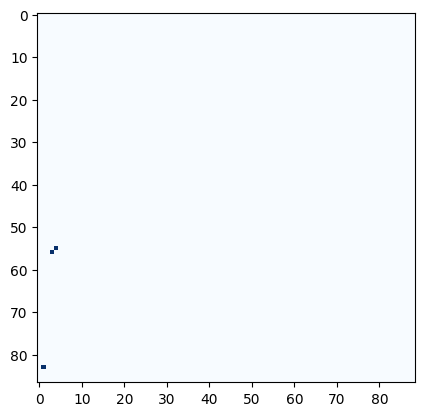

Percentage of non-zero values within the polygon: 4.408413012381337


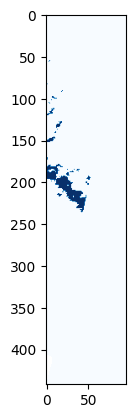

Percentage of non-zero values within the polygon: 14.819960713723503
No overlap


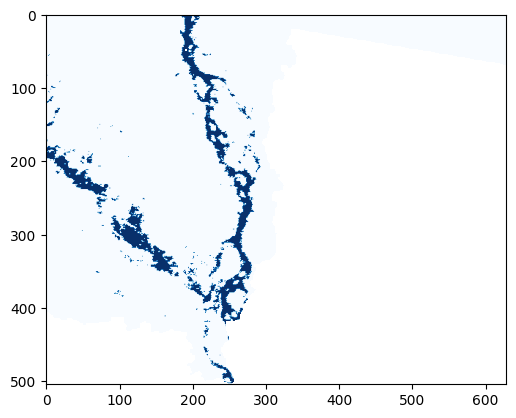

Percentage of non-zero values within the polygon: 99.45108721690268


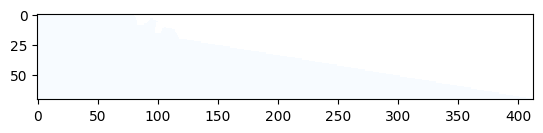

Percentage of non-zero values within the polygon: 0.5448062036726509


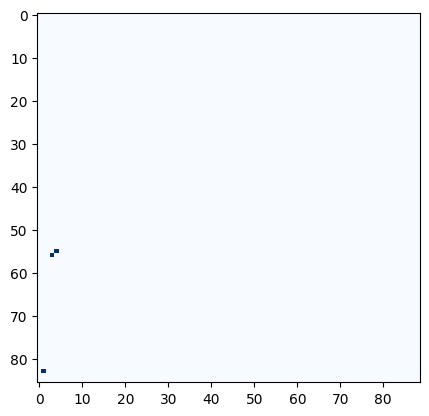

Percentage of non-zero values within the polygon: 4.3830891059292165


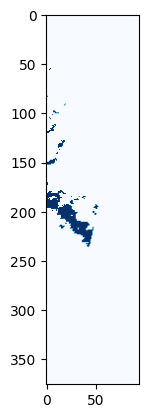

Percentage of non-zero values within the polygon: 14.565352789394073


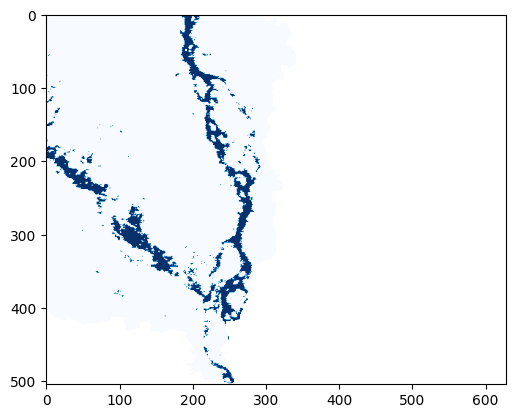

Percentage of non-zero values within the polygon: 100.0


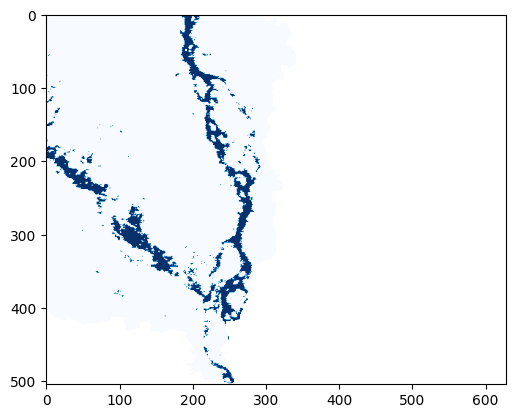

Percentage of non-zero values within the polygon: 100.0


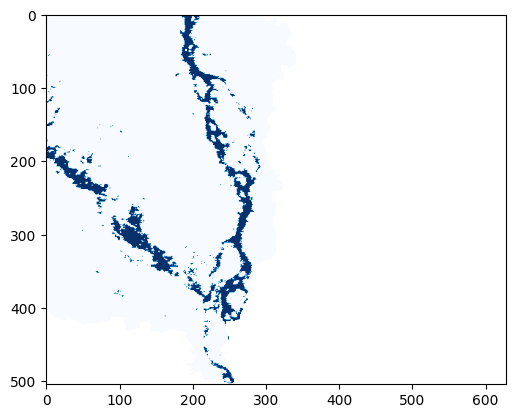

Percentage of non-zero values within the polygon: 100.0
No overlap
No overlap
No overlap


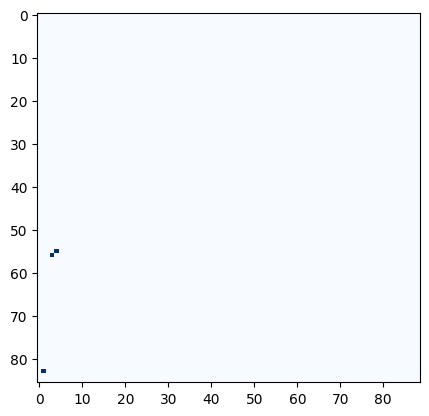

Percentage of non-zero values within the polygon: 4.349552040627759


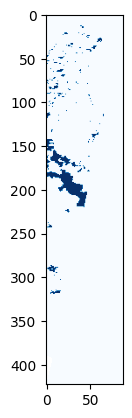

Percentage of non-zero values within the polygon: 11.325058016546832


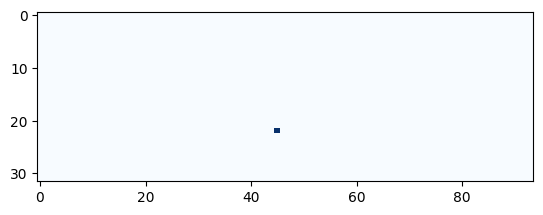

Percentage of non-zero values within the polygon: 1.1688837445333304
No overlap


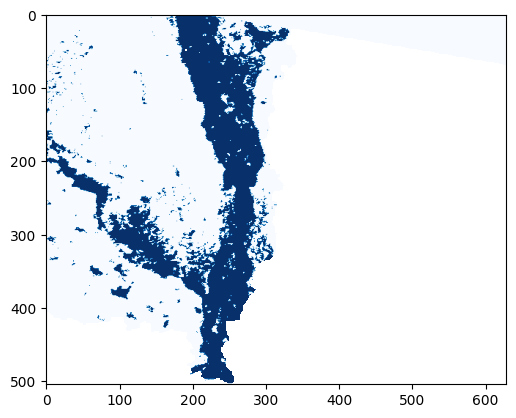

Percentage of non-zero values within the polygon: 99.35112697498589


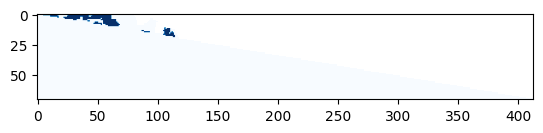

Percentage of non-zero values within the polygon: 0.6329077836253642


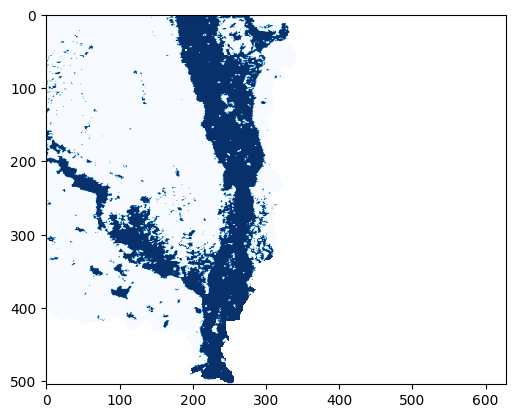

Percentage of non-zero values within the polygon: 100.0


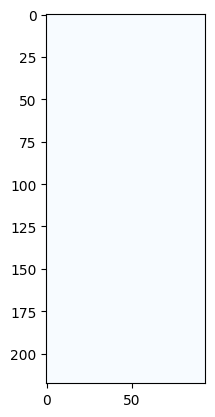

Percentage of non-zero values within the polygon: 4.59739393967322


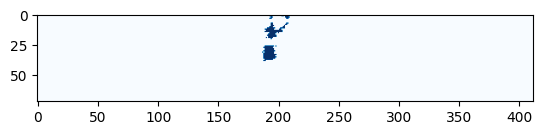

Percentage of non-zero values within the polygon: 4.512604048102903


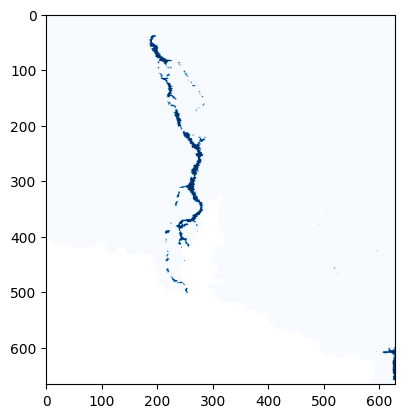

Percentage of non-zero values within the polygon: 95.40444931883918


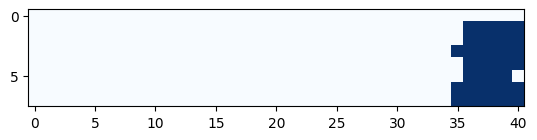

Percentage of non-zero values within the polygon: 0.0657428869422031


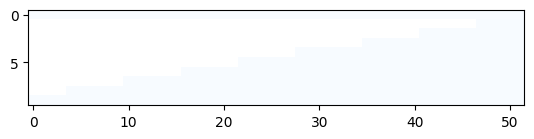

Percentage of non-zero values within the polygon: 0.0


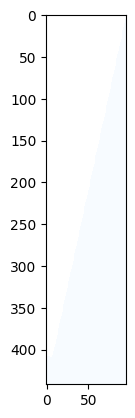

Percentage of non-zero values within the polygon: 0.5824300275036401


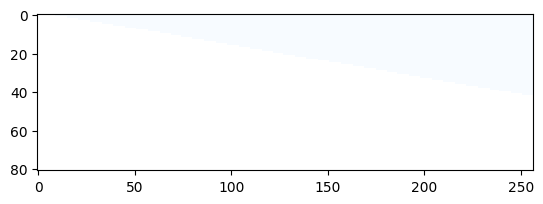

Percentage of non-zero values within the polygon: 0.0


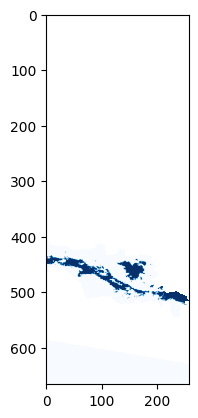

Percentage of non-zero values within the polygon: 100.0


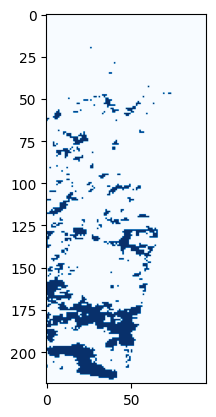

Percentage of non-zero values within the polygon: 3.483604698168577


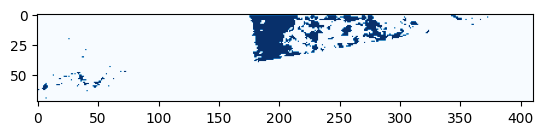

Percentage of non-zero values within the polygon: 3.325735588395108


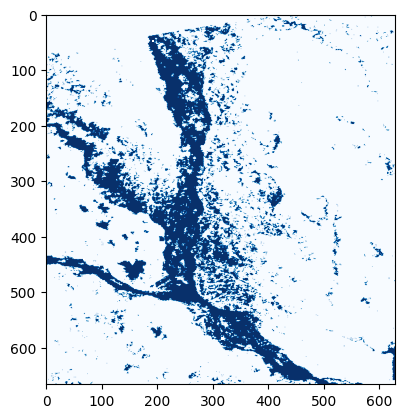

Percentage of non-zero values within the polygon: 96.60672143360475


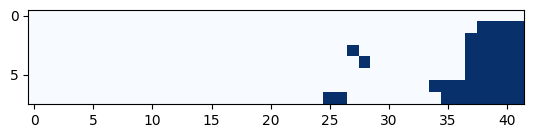

Percentage of non-zero values within the polygon: 0.04496144505681171


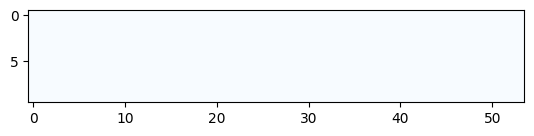

Percentage of non-zero values within the polygon: 0.04475982422696054


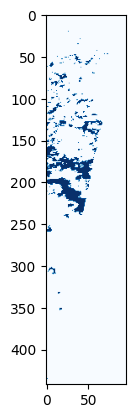

Percentage of non-zero values within the polygon: 4.730629530798086


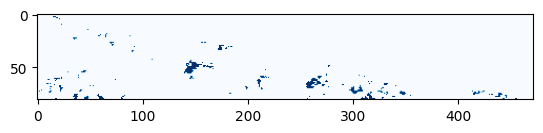

Percentage of non-zero values within the polygon: 4.013867480677163


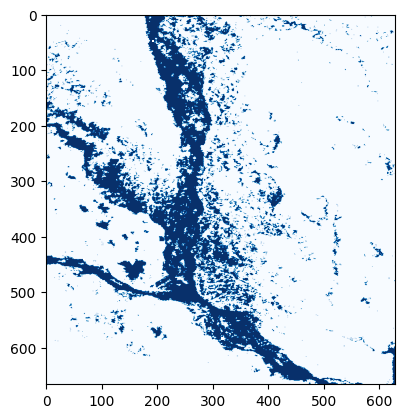

Percentage of non-zero values within the polygon: 95.97443851119148


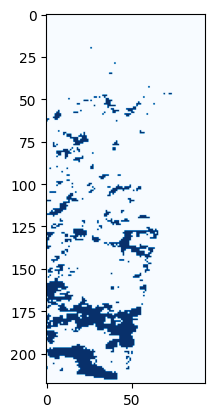

Percentage of non-zero values within the polygon: 3.4527567112013475


In [31]:
# Define the bounding box
bbox = aoi_coords_wgs84

bbox_geom = {
        "type": "Polygon",
        "coordinates": [
            [
                [bbox[0], bbox[1]],
                [bbox[2], bbox[1]],
                [bbox[2], bbox[3]],
                [bbox[0], bbox[3]],
                [bbox[0], bbox[1]]
            ]
        ]
    }

# Set default value 0, for all cases. This value will be updated for the data points where there is coverage of the flood
data['flood_coverage'] = 0.0

for i in range(0, data.shape[0]):
    # If polygon present (visit day)
    polygon_exists = pd.notna(data.loc[i]['id'])
    # If flood in progress on that day
    flood_exists = (data.loc[i]['filename'] != 'No_Event')
    
    if polygon_exists and flood_exists:
        polygon_geometry = {
            'type': 'Polygon',
            'coordinates': [data.loc[i]['polygon']]
        }
        
        polygon = shape(polygon_geometry)
        
        # Combine the bounding box and polygon into a single geometry
        bbox_polygon = box(bbox[0], bbox[1], bbox[2], bbox[3]).intersection(polygon)

        # Open tif flood file
        prefixed = [filename for filename in os.listdir('data/flood/tif') if filename.startswith(data.loc[i].Event_id)]
        with rasterio.open(f'data/flood/tif/{prefixed[0]}') as src:
            try:
                # Mask the raster with the bounding box
                masked_img_bbox, masked_transform_bbox = mask(src, [bbox_geom], crop=True)
            
                # Count the number of non-zero pixels within the bounding box
                non_zero_count_bbox = (masked_img_bbox > 0).sum()
            
                # Mask the resulting image with the polygon
                masked_img_both, masked_transform_both = mask(src, [bbox_polygon], crop=True)
                show(masked_img_both[0], cmap='Blues')  # Using first band of image
            
                # Count the number of non-zero pixels within the polygon
                non_zero_count_both = (masked_img_both > 0).sum()
            
                # Calculate the percentage of non-zero values within the polygon
                percentage_within_polygon = (non_zero_count_both / non_zero_count_bbox) * 100
                data.loc[i, 'flood_coverage'] = percentage_within_polygon
                print("Percentage of non-zero values within the polygon:", percentage_within_polygon)
            except:
                print('No overlap')

    else:
        pass

In [32]:
# Statistics of flood_coverage, for days with image and flood
data[(data.sentinel_visit==1) & (data.flood==1)][['flood_coverage']].describe()

,flood_coverage
count,37.000000
mean,28.968658
std,43.170357
min,0.000000
25%,0.065743
50%,4.349552
75%,95.404449
max,100.000000


In [33]:
# Drop polygon column
data.drop(['polygon'], axis=1, inplace=True)

## EDA

In [34]:
data.drop(['filename', 'id', 'Event_id'], axis=1, inplace=True)

In [35]:
# Construct target variable
target_feature = 'flood_coverage'
data['flood_coverage_bool'] = np.where(data[target_feature] > 5, 1, 0)

In [36]:
# Generate Sweetviz EDA report
report = sv.analyze([data, 'Train'])
report.show_html('EDA_Report.html')

                                             |                                                                …

Report EDA_Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [37]:
# Calculate correlation matrix
correlation_matrix = data.drop(['timestamp'], axis=1, inplace=False).corr()
high_correlation = correlation_matrix[correlation_matrix > 0.85]
display(high_correlation)
high_correlation.to_csv('corr_matrix.csv')

,Year,Month,Day,Rainfall_Bogra,Rainfall_Faridpur,Rainfall_Rajshahi,Rainfall_Rangpur,Rainfall_Tangail,Rainfall_sydpur,Date,...,Cumulative_Rainfall_sydpur_3days,Cumulative_Rainfall_Bogra_5days,Cumulative_Rainfall_Faridpur_5days,Cumulative_Rainfall_Rajshahi_5days,Cumulative_Rainfall_Rangpur_5days,Cumulative_Rainfall_Tangail_5days,Cumulative_Rainfall_sydpur_5days,week_of_year,flood_coverage,flood_coverage_bool
Year,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.940281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.969111,NaN,NaN
Day,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rainfall_Bogra,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rainfall_Faridpur,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rainfall_Rajshahi,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rainfall_Rangpur,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rainfall_Tangail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rainfall_sydpur,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,0.940281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
print(f"First Sentinel image in data set: {data[data.sentinel_visit ==1 ].Date.min().date()}")
print(f"Last Sentinel image in data set: {data[data.sentinel_visit ==1 ].Date.max().date()}")
print(f"First flood event in data set: {data[data.flood == 1 ].Date.min().date()}")
print(f"Last flood event in data set: {data[data.flood ==1 ].Date.max().date()}")

First Sentinel image in data set: 2014-10-15
Last Sentinel image in data set: 2016-12-30
First flood event in data set: 2014-06-23
Last flood event in data set: 2016-08-25


# 2b. Modeling

## Prepare data set

In [39]:
features = [
 'Month',
 'Day',
    
 'week_of_year',

 'total_rainfall',
    
 'Rainfall_Bogra',
 'Rainfall_Faridpur',
 'Rainfall_Rajshahi',
 'Rainfall_Rangpur',
 'Rainfall_Tangail',
 'Rainfall_sydpur',

 # 'Cumulative_Rainfall_Bogra_2days',
 # 'Cumulative_Rainfall_Faridpur_2days',
 # 'Cumulative_Rainfall_Rajshahi_2days',
 # 'Cumulative_Rainfall_Rangpur_2days',
 # 'Cumulative_Rainfall_Tangail_2days',
 # 'Cumulative_Rainfall_sydpur_2days',
    
 # 'Cumulative_Rainfall_Bogra_3days',
 # 'Cumulative_Rainfall_Faridpur_3days',
 # 'Cumulative_Rainfall_Rajshahi_3days',
 # 'Cumulative_Rainfall_Rangpur_3days',
 # 'Cumulative_Rainfall_Tangail_3days',
 # 'Cumulative_Rainfall_sydpur_3days',
    
 # 'Cumulative_Rainfall_Bogra_5days',
 # 'Cumulative_Rainfall_Faridpur_5days',
 # 'Cumulative_Rainfall_Rajshahi_5days',
 # 'Cumulative_Rainfall_Rangpur_5days',
 # 'Cumulative_Rainfall_Tangail_5days',
 # 'Cumulative_Rainfall_sydpur_5days',
]

In [40]:
# Separate target variable
y = data['flood_coverage_bool']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42, shuffle=False)

# Convert the date column to datetime object
date_train = pd.to_datetime(X_train['Date'])
date_test = pd.to_datetime(X_test['Date'])

# Filter for input features only
X_train = X_train[features]
X_test = X_test[features]

In [41]:
# Print info on splits
print("Minimum date in X_train:", date_train.min().date())
print("Maximum date in X_train:", date_train.max().date())
print("Minimum date in X_test:", date_test.min().date())
print("Maximum date in X_test:", date_test.max().date())

# Calculate the percentage of positive labels in y_train
positive_percentage_train = (sum(y_train == 1) / len(y_train)) * 100

# Calculate the percentage of positive labels in y_test
positive_percentage_test = (sum(y_test == 1) / len(y_test)) * 100

print("Percentage of positive labels in y_train:", round(positive_percentage_train, 3))
print("Percentage of positive labels in y_test:", round(positive_percentage_test, 3))

print("Train set size:", X_train.shape)
print("Train set size:", X_test.shape)

Minimum date in X_train: 2014-01-01
Maximum date in X_train: 2016-05-26
Minimum date in X_test: 2016-05-27
Maximum date in X_test: 2016-12-31
Percentage of positive labels in y_train: 1.037
Percentage of positive labels in y_test: 1.24
Train set size: (964, 10)
Train set size: (242, 10)


## Train model

In [42]:
# Create an instance of the XGBClassifier
model = XGBClassifier(objective='binary:logistic', alpha=0.5)

# Fit the model to the training data
model.fit(X_train, y_train)

XGBClassifier(alpha=0.5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [43]:
# Make predictions on train and test sets
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
y_pred_proba_in_sample = model.predict_proba(X_train)

# 3. Model Evaluation

In [44]:
# Calculate ROC AUC
print(f"Train score: {roc_auc_score(y_train, y_pred_proba_in_sample[:,1])}")
print(f"Test score: {roc_auc_score(y_test, y_pred_proba[:,1])}")

Train score: 0.9960167714884696
Test score: 0.8354253835425383


### ROC Curve

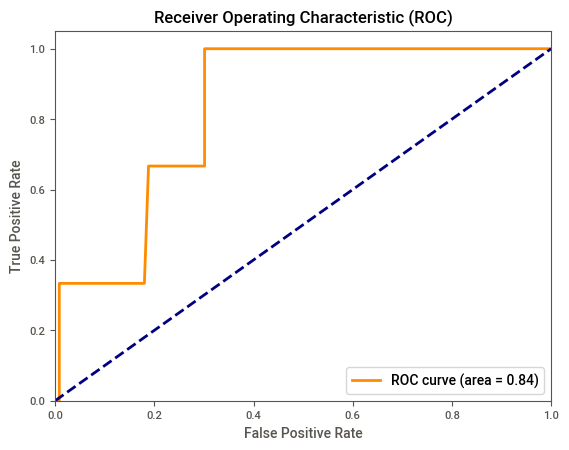

In [45]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# Calculate Area Under Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### Feature Importance

Text(0.5, 0, 'Xgboost Feature Importance')

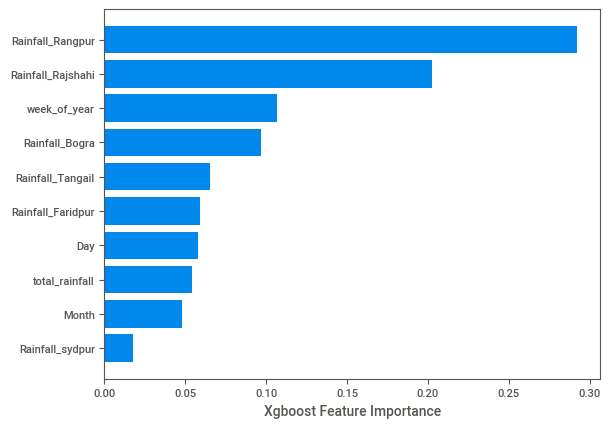

In [46]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(pd.Series(features)[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")